In [4]:
import requests
import json
import pandas as pd
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

# Load APP_TOKEN vairable from keys file
from secret import APP_TOKEN

# Table of contents
* [Overview](#Overview)
* [Data](#Data)
* [Model](#Model)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Overview

The purpose of this project is to create a model to predict the number of crimes that might occur in some chicago neighborhood on any given day. We will be using the Chicago Crimes Dataset, limiting ourselves to the date and community area fields from this set of data. 


## Data <a name="Data"></a>

In [5]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json?$select=date,community_area&$where=year<=2020 AND year >= 2018&$order=date ASC&$limit=1000000"
headers = {'Accept': 'application/json', 'X-App-Token': APP_TOKEN}
resp = requests.get(url,headers=headers)
df = json.loads(resp.text)
df = pd.DataFrame(df)
df

,date,community_area
0,2018-01-01T00:00:00.000,38
1,2018-01-01T00:00:00.000,49
2,2018-01-01T00:00:00.000,48
3,2018-01-01T00:00:00.000,29
4,2018-01-01T00:00:00.000,31
...,...,...
740078,2020-12-31T23:45:00.000,15
740079,2020-12-31T23:45:00.000,32
740080,2020-12-31T23:45:00.000,40
740081,2020-12-31T23:51:00.000,29


In [6]:
# Trasforming data to the the total number of crimes occured each day per community area

# Make a copy of the queried data
df_new = df
# The exact time of crime occured is not necessary, we only keep date data
df_new['date'] = df_new['date'].str[:10]
# count rows that have the same value, this will give us number of crimes for that community_area for a certain day
df_new = df_new.groupby(df.columns.tolist(), as_index=False).size()
# rename columns
df_new.rename({'size': 'num_crimes'}, axis=1, inplace=True)

# convert to date type
df_new['date'] = pd.to_datetime(df_new['date'])
# separate into year, month, day
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month
df_new['day_name'] = df_new['date'].dt.day_name()

df_new

,date,community_area,num_crimes,year,month,day_name
0,2018-01-01,1,11,2018,1,Monday
1,2018-01-01,10,4,2018,1,Monday
2,2018-01-01,11,5,2018,1,Monday
3,2018-01-01,12,5,2018,1,Monday
4,2018-01-01,13,7,2018,1,Monday
...,...,...,...,...,...,...
80255,2020-12-31,75,8,2020,12,Thursday
80256,2020-12-31,76,2,2020,12,Thursday
80257,2020-12-31,77,7,2020,12,Thursday
80258,2020-12-31,8,11,2020,12,Thursday


We will be creating visualizations of the data using the cumulative crime data for the city, as we will be able to detect seasonality from a city wide standpoint.

In [10]:
# total crimes for the entire city per day
df_total_city = df_new
df_total_city = df_new.groupby(df_total_city['date'], as_index=False).size()
df_total_city.set_index('date',inplace=True)

fig = px.line(df_total_city, y="size")
fig.show()

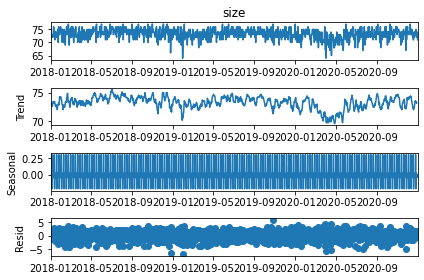

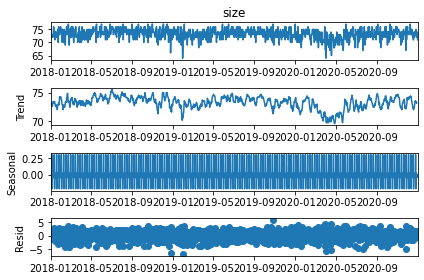

In [15]:
result = seasonal_decompose(df_total_city['size'],  model='additive')
result.plot()

In [ ]:
# total crimes for the entire city per day
df_total_month = df_new
df_total_month = df_total_month.groupby(df_total_month['month'], as_index=False).size()
fig = px.line(df_total_month, x="month", y="size")
fig.show()

In [ ]:
# total crimes for the entire city per day
df_total_day_name = df_new
df_total_day_name = df_total_day_name.groupby(df_total_day_name['day_name'], as_index=False).size()
fig = px.line(df_total_day_name, x="day_name", y="size")
fig.show()

## Model <a name="Model"></a>


## Results <a name="Results"></a>

In [ ]:
test

## Conclusion <a name="Conclusion"></a>
